# MZI filter

In this example we will go over a [Mach–Zehnder interferometer](https://en.wikipedia.org/wiki/Mach%E2%80%93Zehnder_interferometer) filter design.


## Calculations

2023-02-20 18:00:12.652 | INFO     | gdsfactory.config:<module>:50 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.43.1


2023-02-20 18:00:13.529 | INFO     | gdsfactory.technology.layer_views:__init__:785 - Importing LayerViews from YAML file: /home/runner/work/gdsfactory/gdsfactory/gdsfactory/generic_tech/layer_views.yaml.


2023-02-20 18:00:13.536 | INFO     | gdsfactory.pdk:activate:206 - 'generic' PDK is now active


[18:00:14] INFO     Using client version: 1.8.4                                                     ]8;id=828585;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py\__init__.py]8;;\:]8;id=51567;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py#120\120]8;;\

2023-02-20 18:00:14.876 | INFO     | gdsfactory.simulation.gtidy3d:<module>:54 - Tidy3d '1.8.4' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d']


pi_length = 1452um for 1nm width variation
pi_length = 290um for 5nm width variation
pi_length = 145um for 10nm width variation


           WARNING  No artists with labels found to put in legend.  Note that artists whose label    ]8;id=855659;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=558298;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/matplotlib/legend.py#1330\1330]8;;\
                    start with an underscore are ignored when legend() is called with no argument.                 

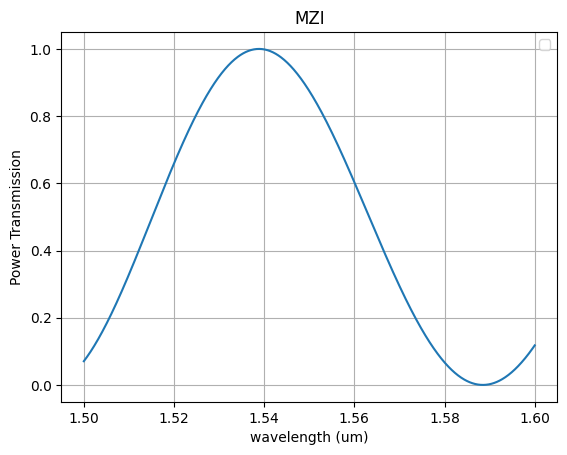

In [1]:
from typing import Optional

import numpy as np
import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()


def mzi(
    wl: np.ndarray,
    neff: Optional[float],
    neff1: Optional[float] = None,
    neff2: Optional[float] = None,
    delta_length: Optional[float] = None,
    length1: Optional[float] = 0,
    length2: Optional[float] = None,
) -> np.ndarray:
    """Returns Frequency Domain Response of an MZI interferometer in linear units.

    Args:
        wl: wavelength in  um.
        neff: effective index.
        neff1: effective index branch 1.
        neff2: effective index branch 2.
        delta_length: length difference L2-L1.
        length1: length of branch 1.
        length2: length of branch 2.
    """
    k_0 = 2 * np.pi / wl
    length2 = length2 or length1 + delta_length
    delta_length = delta_length or np.abs(length2 - length1)
    neff1 = neff1 or neff
    neff2 = neff2 or neff

    E_out = 0.5 * (
        np.exp(1j * k_0 * neff1 * (length1 + delta_length))
        + np.exp(1j * k_0 * neff2 * length1)
    )
    return np.abs(E_out) ** 2


if __name__ == "__main__":
    import gdsfactory.simulation.gtidy3d as gt
    import matplotlib.pyplot as plt

    nm = 1e-3
    strip = gt.modes.Waveguide(
        wavelength=1.55,
        wg_width=500 * nm,
        wg_thickness=220 * nm,
        slab_thickness=0.0,
        ncore=gt.modes.si,
        nclad=gt.modes.sio2,
    )

    neff = 2.46  # Effective index of the waveguides
    wl0 = 1.55  # [μm] the wavelength at which neff and ng are defined
    wl = np.linspace(1.5, 1.6, 1000)  # [μm] Wavelengths to sweep over
    ngs = [4.182551, 4.169563, 4.172917]
    thicknesses = [210, 220, 230]

    length = 4e3
    dn = np.pi / length

    polyfit_TE1550SOI_220nm = np.array(
        [
            1.02478963e-09,
            -8.65556534e-08,
            3.32415694e-06,
            -7.68408985e-05,
            1.19282177e-03,
            -1.31366332e-02,
            1.05721429e-01,
            -6.31057637e-01,
            2.80689677e00,
            -9.26867694e00,
            2.24535191e01,
            -3.90664800e01,
            4.71899278e01,
            -3.74726005e01,
            1.77381560e01,
            -1.12666286e00,
        ]
    )
    neff_w = lambda w: np.poly1d(polyfit_TE1550SOI_220nm)(w)

    w0 = 450 * nm
    dn1 = neff_w(w0 + 1 * nm / 2) - neff_w(w0 - 1 * nm / 2)
    dn5 = neff_w(w0 + 5 * nm / 2) - neff_w(w0 - 5 * nm / 2)
    dn10 = neff_w(w0 + 10 * nm / 2) - neff_w(w0 - 10 * nm / 2)

    pi_length1 = np.pi / dn1
    pi_length5 = np.pi / dn5
    pi_length10 = np.pi / dn10

    print(f"pi_length = {pi_length1:.0f}um for 1nm width variation")
    print(f"pi_length = {pi_length5:.0f}um for 5nm width variation")
    print(f"pi_length = {pi_length10:.0f}um for 10nm width variation")

    dn = dn1
    p = mzi(wl, neff=neff, neff1=neff + dn, neff2=neff + dn, delta_length=10)
    plt.plot(wl, p)
    plt.title("MZI")
    plt.xlabel("wavelength (um)")
    plt.ylabel("Power Transmission")
    plt.grid()
    plt.legend()
    plt.show()

## Mode solver

For waveguides you can compute the EM modes.

2023-02-20 18:00:15.064 | INFO     | gdsfactory.simulation.gtidy3d.modes:compute_modes:439 - load /home/runner/.gdsfactory/modes/4a9b4373.npz mode data from file cache.


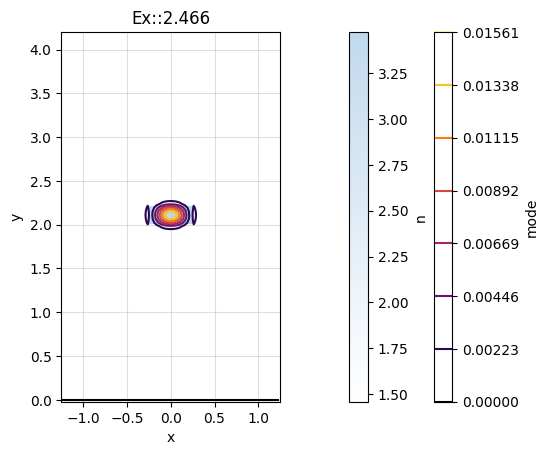

In [2]:
import numpy as np
import gdsfactory.simulation.gtidy3d as gt
import matplotlib.pyplot as plt

nm = 1e-3
strip = gt.modes.Waveguide(
    wavelength=1.55,
    wg_width=0.5,
    wg_thickness=0.22,
    slab_thickness=0.0,
    ncore="si",
    nclad="sio2",
)
strip.plot_Ex(0)  # TE

In [3]:
nm = 1e-3
ng = gt.modes.group_index(
    wg_width=500 * nm,
    wavelength=1.55,
    wg_thickness=220 * nm,
    slab_thickness=0 * nm,
    ncore="si",
    nclad="sio2",
)
print(ng)

2023-02-20 18:00:15.384 | INFO     | gdsfactory.simulation.gtidy3d.modes:compute_modes:439 - load /home/runner/.gdsfactory/modes/4a9b4373.npz mode data from file cache.


2023-02-20 18:00:15.405 | INFO     | gdsfactory.simulation.gtidy3d.modes:compute_modes:439 - load /home/runner/.gdsfactory/modes/ba607431.npz mode data from file cache.


2023-02-20 18:00:15.426 | INFO     | gdsfactory.simulation.gtidy3d.modes:compute_modes:439 - load /home/runner/.gdsfactory/modes/a7a6b1cb.npz mode data from file cache.


4.1703596115112305


## FDTD 

Lets compute the Sparameters of a 1x2 power splitter using [tidy3D](https://docs.flexcompute.com/projects/tidy3d/en/latest/), which is a fast GPU based FDTD commercial solver.

To run, you need to [create an account](https://simulation.cloud/) and add credits. The number of credits that each simulation takes depends on the simulation computation time.

![cloud_model](https://i.imgur.com/5VTCPLR.png)

In [4]:
import gdsfactory.simulation as sim
import gdsfactory as gf
import gdsfactory.simulation.gtidy3d as gt

import gdsfactory.components as pdk

In [5]:
c = pdk.mmi1x2()
c

AppLayout(children=(Tab(children=(VBox(children=(HBox(children=(Button(layout=Layout(border_bottom='solid 2px …

mmi1x2: uid 05b18f0c, ports ['o1', 'o2', 'o3'], references [], 4 polygons


In [6]:
sp = gt.write_sparameters(c)

2023-02-20 18:00:16.163 | INFO     | gdsfactory.simulation.gtidy3d.write_sparameters:write_sparameters:163 - Simulation loaded from PosixPath('/home/runner/.gdsfactory/sp/mmi1x2_c3ff7345.npz')


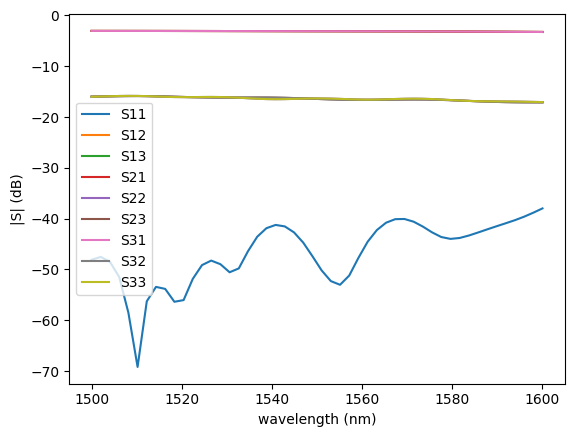

In [7]:
sim.plot.plot_sparameters(sp)

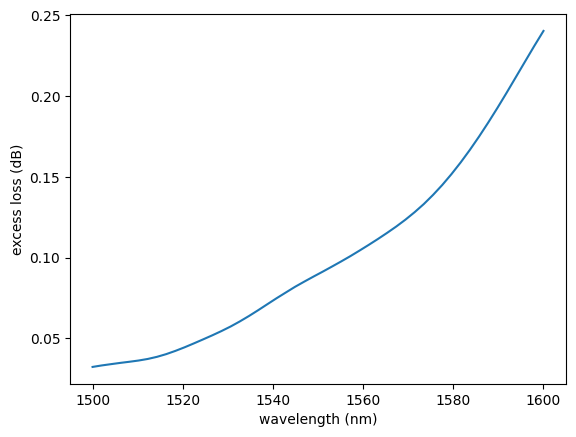

In [8]:
sim.plot.plot_loss1x2(sp)

## Circuit simulation

For the simulations you need to build Sparameters models for your components using FDTD or other methods.

![demo](https://i.imgur.com/RSOTDIN.png)

Sparameters are common in RF and photonic simulation.

We are going to simulate a MZI interferometer circuit.
For that we need to simulate each of the component Sparameters in tidy3d and then SAX Sparameter circuit solver to solve the Sparameters for the circuit.

We will be using SAX which is an open source circuit simulator.


```
set PIP_FIND_LINKS="https://whls.blob.core.windows.net/unstable/index.html"
pip install sax jax sklearn
pip install "jaxlib[cuda111]" -f https://whls.blob.core.windows.net/unstable/index.html --use-deprecated legacy-resolver
pip install "gdsfactory[tidy3d,sax]"
```

In [9]:
mzi10 = gf.components.mzi(splitter=c, delta_length=10)
mzi10

AppLayout(children=(Tab(children=(VBox(children=(HBox(children=(Button(layout=Layout(border_bottom='solid 2px …

mzi_eec2d2e0: uid f88d528d, ports ['o1', 'o2'], references ['bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'straight_5', 'straight_6', 'straight_7', 'bend_euler_7', 'bend_euler_8', 'straight_8', 'straight_9', 'straight_10', 'sytl', 'syl', 'sxt', 'sxb', 'cp1', 'cp2'], 0 polygons


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from omegaconf import OmegaConf
import sax

import gdsfactory as gf
import gdsfactory.simulation.sax as gsax

In [11]:
def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    wl0 = 1.5  # center wavelength for which the waveguide model is defined
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})


def bend_euler(wl=1.5, length=20.0):
    """Assumes a reduced transmission for the euler bend compared to a straight"""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}

In [12]:
mmi1x2 = gsax.read.model_from_npz(sp)
models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,
}

[18:00:17] INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver   ]8;id=410981;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=912456;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py#421\421]8;;\
                    in registry given worker:                                                                      

           INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no     ]8;id=392971;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=649005;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py#421\421]8;;\
                    attribute 'GpuAllocatorConfig'                                                                 

           INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no     ]8;id=415823;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=474384;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py#421\421]8;;\
                    attribute 'GpuAllocatorConfig'                                                                 

           INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not      ]8;id=988477;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=484428;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py#421\421]8;;\
                    available.                                                                                     

           INFO     Unable to initialize backend 'plugin': xla_extension has no attributes named  ]8;id=549018;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=449860;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py#421\421]8;;\
                    get_plugin_device_client. Compile TensorFlow with                                              
                    //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults                    
                    to false) to enable this.                                                                      

           WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun  ]8;id=738617;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py\xla_bridge.py]8;;\:]8;id=907986;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py#428\428]8;;\
                    for more info.)                                                                                

In [13]:
netlist = mzi10.get_netlist()
circuit, _ = sax.circuit(netlist=netlist, models=models)

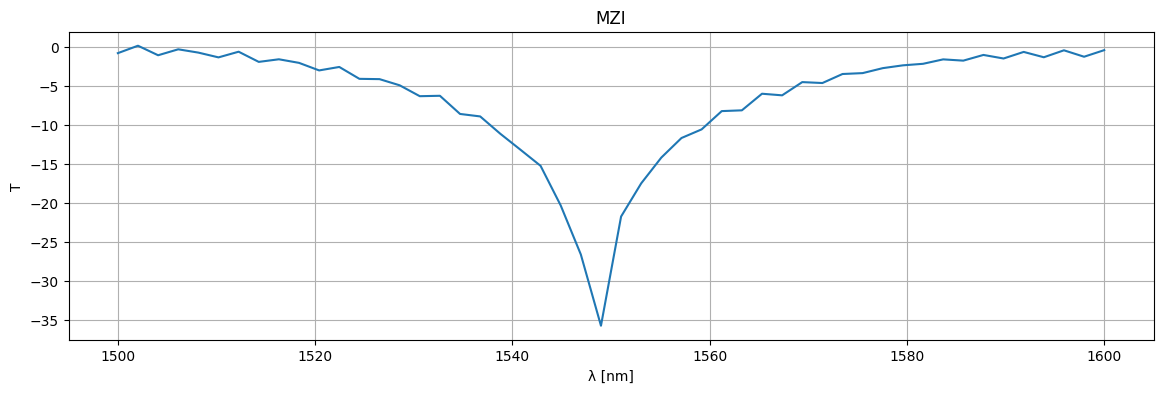

In [14]:
wl = np.linspace(1.5, 1.6)
S = circuit(wl=wl)
plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, 10 * np.log10(jnp.abs(S["o1", "o2"]) ** 2))
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()

In [15]:
mzi20 = gf.components.mzi(splitter=c, delta_length=20)
mzi20

AppLayout(children=(Tab(children=(VBox(children=(HBox(children=(Button(layout=Layout(border_bottom='solid 2px …

mzi_c64dbb04: uid 486510d8, ports ['o1', 'o2'], references ['bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'straight_5', 'straight_6', 'straight_7', 'bend_euler_7', 'bend_euler_8', 'straight_8', 'straight_9', 'straight_10', 'sytl', 'syl', 'sxt', 'sxb', 'cp1', 'cp2'], 0 polygons


In [16]:
netlist = mzi20.get_netlist()
circuit, _ = sax.circuit(netlist=netlist, models=models)

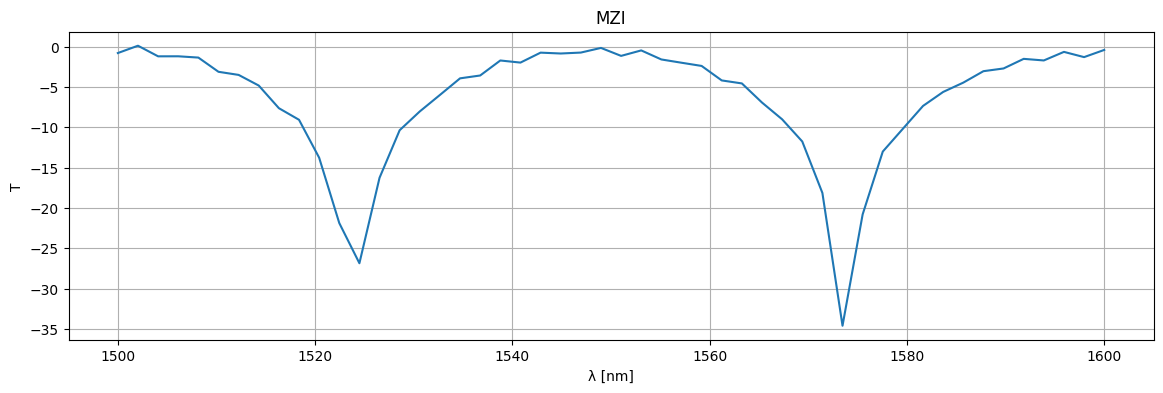

In [17]:
wl = np.linspace(1.5, 1.6)
S = circuit(wl=wl)
plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, 10 * np.log10(jnp.abs(S["o1", "o2"]) ** 2))
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()